# Análisis exploratorio de datos (EDA)

Notebook para la comprensión inicial del dataset de calidad de vino. Se incluyen: carga, tipos, nulos, resumen univariable, análisis bivariado respecto a la variable objetivo `quality`, y matriz de correlación.

In [17]:
%pip install matplotlib seaborn lightgbm scipy colorama

from time import time
from datetime import timedelta
from colorama import Fore, Style

import math
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import lightgbm as lgbm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings

def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': bg_color,
    'axes.facecolor': bg_color
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params
)

warnings.simplefilter("ignore", UserWarning)

Note: you may need to restart the kernel to use updated packages.


## 1) Descripción de los Datos

### Dataset: Wine Quality (Calidad del Vino)

El conjunto de datos fue generado utilizando el Wine Quality Dataset. La tarea consiste en predecir la calidad del vino, que es una variable ordinal.

**Aspectos clave:**
- Las distribuciones de las características son similares, pero no exactamente iguales, a las originales
- Se puede utilizar el conjunto de datos original como parte del aumento de datos
- Dataset ligero que permite utilizar múltiples algoritmos
- El problema se plantea como regresión ordinal, aunque podría abordarse como clasificación

**Variables de entrada (basadas en pruebas fisicoquímicas):**

1. **fixed_acidity** (acidez fija - ácido tartárico g/dm³): Mayoría de ácidos presentes en el vino son fijos o no volátiles
2. **volatile_acidity** (acidez volátil - ácido acético g/dm³): Cantidad de ácido acético en el vino; niveles altos provocan sabor a vinagre
3. **citric_acid** (ácido cítrico g/dm³): En pequeñas cantidades añade frescura y sabor
4. **residual_sugar** (azúcar residual g/dm³): Azúcar que permanece después de la fermentación; >45 g/L se consideran vinos dulces
5. **chlorides** (cloruros - cloruro de sodio g/dm³): Cantidad de sal en el vino
6. **free_sulfur_dioxide** (dióxido de azufre libre mg/dm³): Impide crecimiento microbiano y oxidación
7. **total_sulfur_dioxide** (dióxido de azufre total mg/dm³): Suma de formas libres y unidas de SO2
8. **density** (densidad g/cm³): Densidad similar al agua, depende del alcohol y azúcar
9. **pH**: Grado de acidez o alcalinidad (0-14); la mayoría de vinos entre 3-4
10. **sulphates** (sulfatos - sulfato de potasio g/dm³): Actúa como antimicrobiano y antioxidante
11. **alcohol** (% en volumen): Porcentaje de alcohol del vino

**Variable objetivo (basada en datos sensoriales):**
- **quality** (calidad): Puntuación entre 3 y 8

In [18]:

%pip install scikit-learn

from pathlib import Path
data_path = Path('../../Base_de_datos.csv')
if not data_path.exists():
    raise FileNotFoundError(f'Dataset no encontrado en {data_path.resolve()}')
df = pd.read_csv(data_path)

if 'quality' not in df.columns:
    raise ValueError('Se espera una columna objetivo llamada en Base_de_datos.csv')

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df.quality if df.quality.nunique()>1 else None)
original_df = df.copy()


train_df.columns = train_df.columns.str.replace(' ', '_')
original_df.columns = original_df.columns.str.replace(' ', '_')
test_df.columns = test_df.columns.str.replace(' ', '_')

features = [c for c in train_df.columns if c != 'quality']

Note: you may need to restart the kernel to use updated packages.


In [19]:
print('Train')
display(train_df.quality.value_counts(True))

print('\nOriginal')
display(original_df.quality.value_counts(True))

Train


quality
5    0.422319
6    0.404814
7    0.124726
4    0.028446
8    0.014223
3    0.005470
Name: proportion, dtype: float64


Original


quality
5    0.422572
6    0.404199
7    0.125109
4    0.028871
8    0.013998
3    0.005249
Name: proportion, dtype: float64

## 2) Exploración Inicial de Datos

### Caracterización de Variables

En esta sección se realiza una exploración detallada de las características del dataset, identificando tipos de datos y validando la calidad de la información.

In [20]:
# Información general del dataset
print("="*80)
print("INFORMACIÓN GENERAL DEL DATASET DE ENTRENAMIENTO")
print("="*80)
print(f"\n Dimensiones: {train_df.shape[0]} filas × {train_df.shape[1]} columnas")
print(f" Tamaño en memoria: {train_df.memory_usage(deep=True).sum() / 1024:.2f} KB\n")

print("\n" + "="*80)
print("TIPOS DE DATOS POR COLUMNA")
print("="*80)
print(train_df.dtypes)

print("\n" + "="*80)
print("CARACTERIZACIÓN DE VARIABLES")
print("="*80)

# Clasificación de variables
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('quality')  # Excluir target

categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n Variables NUMÉRICAS ({len(numeric_cols)}):")
print(f"   {', '.join(numeric_cols)}")
print(f"\n   Todas son variables CONTINUAS (mediciones fisicoquímicas)")

print(f"\n Variable OBJETIVO (1):")
print(f"   quality → ORDINAL (rango 3-8, orden natural de calidad)")

print(f"\n Variables CATEGÓRICAS ({len(categorical_cols)}):")
if len(categorical_cols) > 0:
    print(f"   {', '.join(categorical_cols)}")
else:
    print(f"    No hay variables categóricas en este dataset")

print("\n" + "="*80)
print("REVISIÓN DE VALORES NULOS")
print("="*80)
nulls = train_df.isnull().sum()
print(nulls[nulls > 0] if nulls.sum() > 0 else "✅ No se encontraron valores nulos en el dataset")

INFORMACIÓN GENERAL DEL DATASET DE ENTRENAMIENTO

 Dimensiones: 914 filas × 13 columnas
 Tamaño en memoria: 99.97 KB


TIPOS DE DATOS POR COLUMNA
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Id                        int64
dtype: object

CARACTERIZACIÓN DE VARIABLES

 Variables NUMÉRICAS (12):
   fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, Id

   Todas son variables CONTINUAS (mediciones fisicoquímicas)

 Variable OBJETIVO (1):
   quality → ORDINAL (rango 3-8, orden natural de calidad)

 Variables CATEGÓRICAS (0):
    No hay variables categóricas en 

### Análisis Univariable - Estadísticas Descriptivas

Análisis detallado de las medidas de tendencia central, dispersión y forma de la distribución para cada variable numérica.

In [21]:
# Estadísticas descriptivas básicas
print("="*80)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
print("="*80)
display(train_df[numeric_cols].describe().T)

# Estadísticas adicionales: skewness y kurtosis
print("\n" + "="*80)
print("MEDIDAS DE FORMA DE LA DISTRIBUCIÓN")
print("="*80)

stats_df = pd.DataFrame({
    'Media': train_df[numeric_cols].mean(),
    'Mediana': train_df[numeric_cols].median(),
    'Desv.Std': train_df[numeric_cols].std(),
    'Varianza': train_df[numeric_cols].var(),
    'Skewness': train_df[numeric_cols].skew(),
    'Kurtosis': train_df[numeric_cols].kurtosis(),
    'Min': train_df[numeric_cols].min(),
    'Max': train_df[numeric_cols].max(),
    'Rango': train_df[numeric_cols].max() - train_df[numeric_cols].min(),
    'IQR': train_df[numeric_cols].quantile(0.75) - train_df[numeric_cols].quantile(0.25)
})

display(stats_df.round(3))

print("\n" + "="*80)
print("INTERPRETACIÓN DE SKEWNESS Y KURTOSIS")
print("="*80)

for col in numeric_cols:
    skew = train_df[col].skew()
    kurt = train_df[col].kurtosis()
    
    # Clasificar distribución por skewness
    if abs(skew) < 0.5:
        dist_type = "SIMÉTRICA (distribución normal)"
    elif skew > 0:
        dist_type = "SESGADA A LA DERECHA (cola larga hacia valores altos)"
    else:
        dist_type = "SESGADA A LA IZQUIERDA (cola larga hacia valores bajos)"
    
    # Clasificar por kurtosis
    if abs(kurt) < 0.5:
        kurt_type = "MESOCÚRTICA (similar a normal)"
    elif kurt > 0:
        kurt_type = "LEPTOCÚRTICA (pico más pronunciado, colas pesadas)"
    else:
        kurt_type = "PLATICÚRTICA (más plana que normal)"
    
    print(f"\n {col}:")
    print(f"   Skewness: {skew:.3f} → {dist_type}")
    print(f"   Kurtosis: {kurt:.3f} → {kurt_type}")

ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS


,count,mean,std,min,25%,50%,75%,max
fixed_acidity,914.0,8.321116,1.745996,4.60000,7.100000,7.9000,9.100000,15.9000
volatile_acidity,914.0,0.530563,0.178743,0.12000,0.390000,0.5200,0.640000,1.5800
citric_acid,914.0,0.271313,0.195437,0.00000,0.100000,0.2550,0.420000,1.0000
residual_sugar,914.0,2.514497,1.190465,0.90000,1.900000,2.2000,2.600000,13.8000
chlorides,914.0,0.087447,0.050122,0.01200,0.070000,0.0790,0.090000,0.6110
free_sulfur_dioxide,914.0,15.444748,10.021770,1.00000,7.000000,13.0000,21.000000,68.0000
total_sulfur_dioxide,914.0,45.830963,33.160008,6.00000,21.000000,37.0000,61.000000,289.0000
density,914.0,0.996732,0.001912,0.99007,0.995572,0.9967,0.997823,1.0032
pH,914.0,3.310088,0.154087,2.74000,3.210000,3.3100,3.400000,4.0100
sulphates,914.0,0.656980,0.173762,0.33000,0.550000,0.6200,0.720000,2.0000



MEDIDAS DE FORMA DE LA DISTRIBUCIÓN


,Media,Mediana,Desv.Std,Varianza,Skewness,Kurtosis,Min,Max,Rango,IQR
fixed_acidity,8.321,7.900,1.746,3.049,1.071,1.488,4.600,15.900,11.300,2.000
volatile_acidity,0.531,0.520,0.179,0.032,0.709,1.644,0.120,1.580,1.460,0.250
citric_acid,0.271,0.255,0.195,0.038,0.376,-0.657,0.000,1.000,1.000,0.320
residual_sugar,2.514,2.200,1.190,1.417,3.277,15.492,0.900,13.800,12.900,0.700
chlorides,0.087,0.079,0.050,0.003,5.915,44.133,0.012,0.611,0.599,0.020
free_sulfur_dioxide,15.445,13.000,10.022,100.436,1.176,1.739,1.000,68.000,67.000,14.000
total_sulfur_dioxide,45.831,37.000,33.160,1099.586,1.760,5.895,6.000,289.000,283.000,40.000
density,0.997,0.997,0.002,0.000,0.053,0.789,0.990,1.003,0.013,0.002
pH,3.310,3.310,0.154,0.024,0.121,0.758,2.740,4.010,1.270,0.190
sulphates,0.657,0.620,0.174,0.030,2.659,13.186,0.330,2.000,1.670,0.170



INTERPRETACIÓN DE SKEWNESS Y KURTOSIS

 fixed_acidity:
   Skewness: 1.071 → SESGADA A LA DERECHA (cola larga hacia valores altos)
   Kurtosis: 1.488 → LEPTOCÚRTICA (pico más pronunciado, colas pesadas)

 volatile_acidity:
   Skewness: 0.709 → SESGADA A LA DERECHA (cola larga hacia valores altos)
   Kurtosis: 1.644 → LEPTOCÚRTICA (pico más pronunciado, colas pesadas)

 citric_acid:
   Skewness: 0.376 → SIMÉTRICA (distribución normal)
   Kurtosis: -0.657 → PLATICÚRTICA (más plana que normal)

 residual_sugar:
   Skewness: 3.277 → SESGADA A LA DERECHA (cola larga hacia valores altos)
   Kurtosis: 15.492 → LEPTOCÚRTICA (pico más pronunciado, colas pesadas)

 chlorides:
   Skewness: 5.915 → SESGADA A LA DERECHA (cola larga hacia valores altos)
   Kurtosis: 44.133 → LEPTOCÚRTICA (pico más pronunciado, colas pesadas)

 free_sulfur_dioxide:
   Skewness: 1.176 → SESGADA A LA DERECHA (cola larga hacia valores altos)
   Kurtosis: 1.739 → LEPTOCÚRTICA (pico más pronunciado, colas pesadas)

 total

ANÁLISIS DE LA VARIABLE OBJETIVO: quality

 Distribución de clases:


,Frecuencia,Porcentaje (%)
quality,,
3,5,0.55
4,26,2.84
5,386,42.23
6,370,40.48
7,114,12.47
8,13,1.42



 Tipo de variable: ORDINAL
 Rango: 3 - 8
 Moda: 5 (clase más frecuente)
 Media: 5.66
 Mediana: 6.0

 Observaciones:
   • Clases mayoritarias: 5 y 6 (vinos de calidad media)
   • Clases minoritarias: 3, 4, 7, 8 (extremos de calidad)
   • Desbalanceo presente → usar StratifiedKFold en validación


C:\Users\Marlon\AppData\Local\Temp\ipykernel_16492\1751079283.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='quality', palette=palette, ax=ax1)


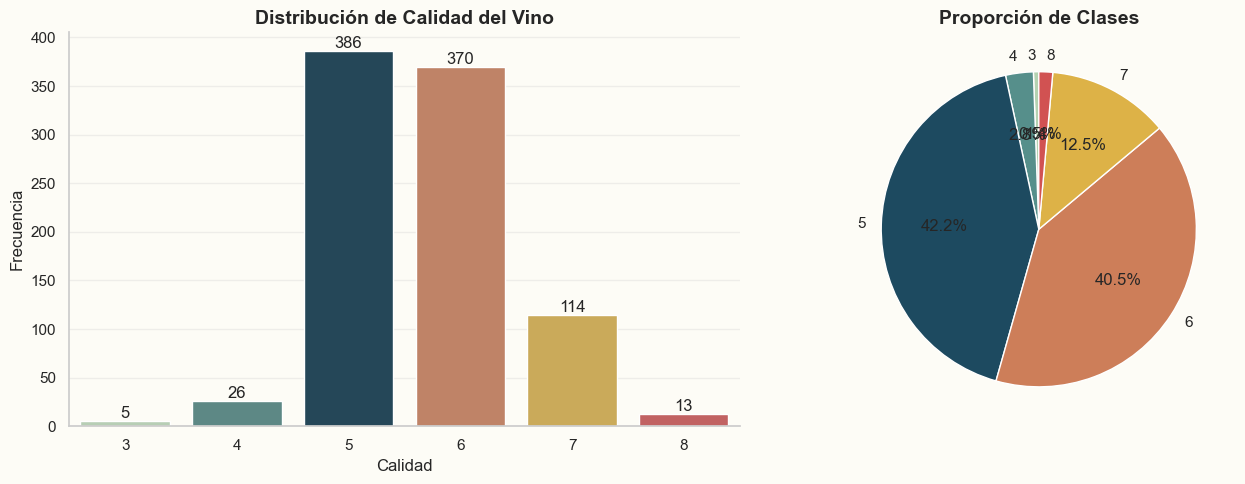

In [22]:
# Análisis de la variable objetivo
print("="*80)
print("ANÁLISIS DE LA VARIABLE OBJETIVO: quality")
print("="*80)

print("\n Distribución de clases:")
quality_dist = train_df['quality'].value_counts().sort_index()
quality_pct = (train_df['quality'].value_counts(normalize=True).sort_index() * 100).round(2)

quality_summary = pd.DataFrame({
    'Frecuencia': quality_dist,
    'Porcentaje (%)': quality_pct
})
display(quality_summary)

print(f"\n Tipo de variable: ORDINAL")
print(f" Rango: {train_df['quality'].min()} - {train_df['quality'].max()}")
print(f" Moda: {train_df['quality'].mode()[0]} (clase más frecuente)")
print(f" Media: {train_df['quality'].mean():.2f}")
print(f" Mediana: {train_df['quality'].median()}")

print("\n Observaciones:")
print("   • Clases mayoritarias: 5 y 6 (vinos de calidad media)")
print("   • Clases minoritarias: 3, 4, 7, 8 (extremos de calidad)")
print("   • Desbalanceo presente → usar StratifiedKFold en validación")

# Visualización de la distribución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Countplot
sns.countplot(data=train_df, x='quality', palette=palette, ax=ax1)
ax1.set_title('Distribución de Calidad del Vino', fontsize=14, fontweight='bold')
ax1.set_xlabel('Calidad', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)

# Agregar porcentajes en las barras
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d')

# Pie chart
ax2.pie(quality_dist, labels=quality_dist.index, autopct='%1.1f%%', 
        colors=palette[:len(quality_dist)], startangle=90)
ax2.set_title('Proporción de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4) Análisis Exploratorio de Datos (EDA)

### Tamaño de los datos

**Conclusiones:**

- Se trata de un conjunto de datos ligero, lo que permite utilizar varios modelos, conjuntos, ingeniería de características y múltiples técnicas sin necesidad de gran potencia computacional.
- El conjunto de datos original tiene menos registros que el conjunto de datos sintéticos.

In [23]:
print('Train shape:            ', train_df.shape)
print('Test shape:             ', test_df.shape)
print('Original Dataset shape: ', original_df.shape)

Train shape:             (914, 13)
Test shape:              (229, 13)
Original Dataset shape:  (1143, 13)


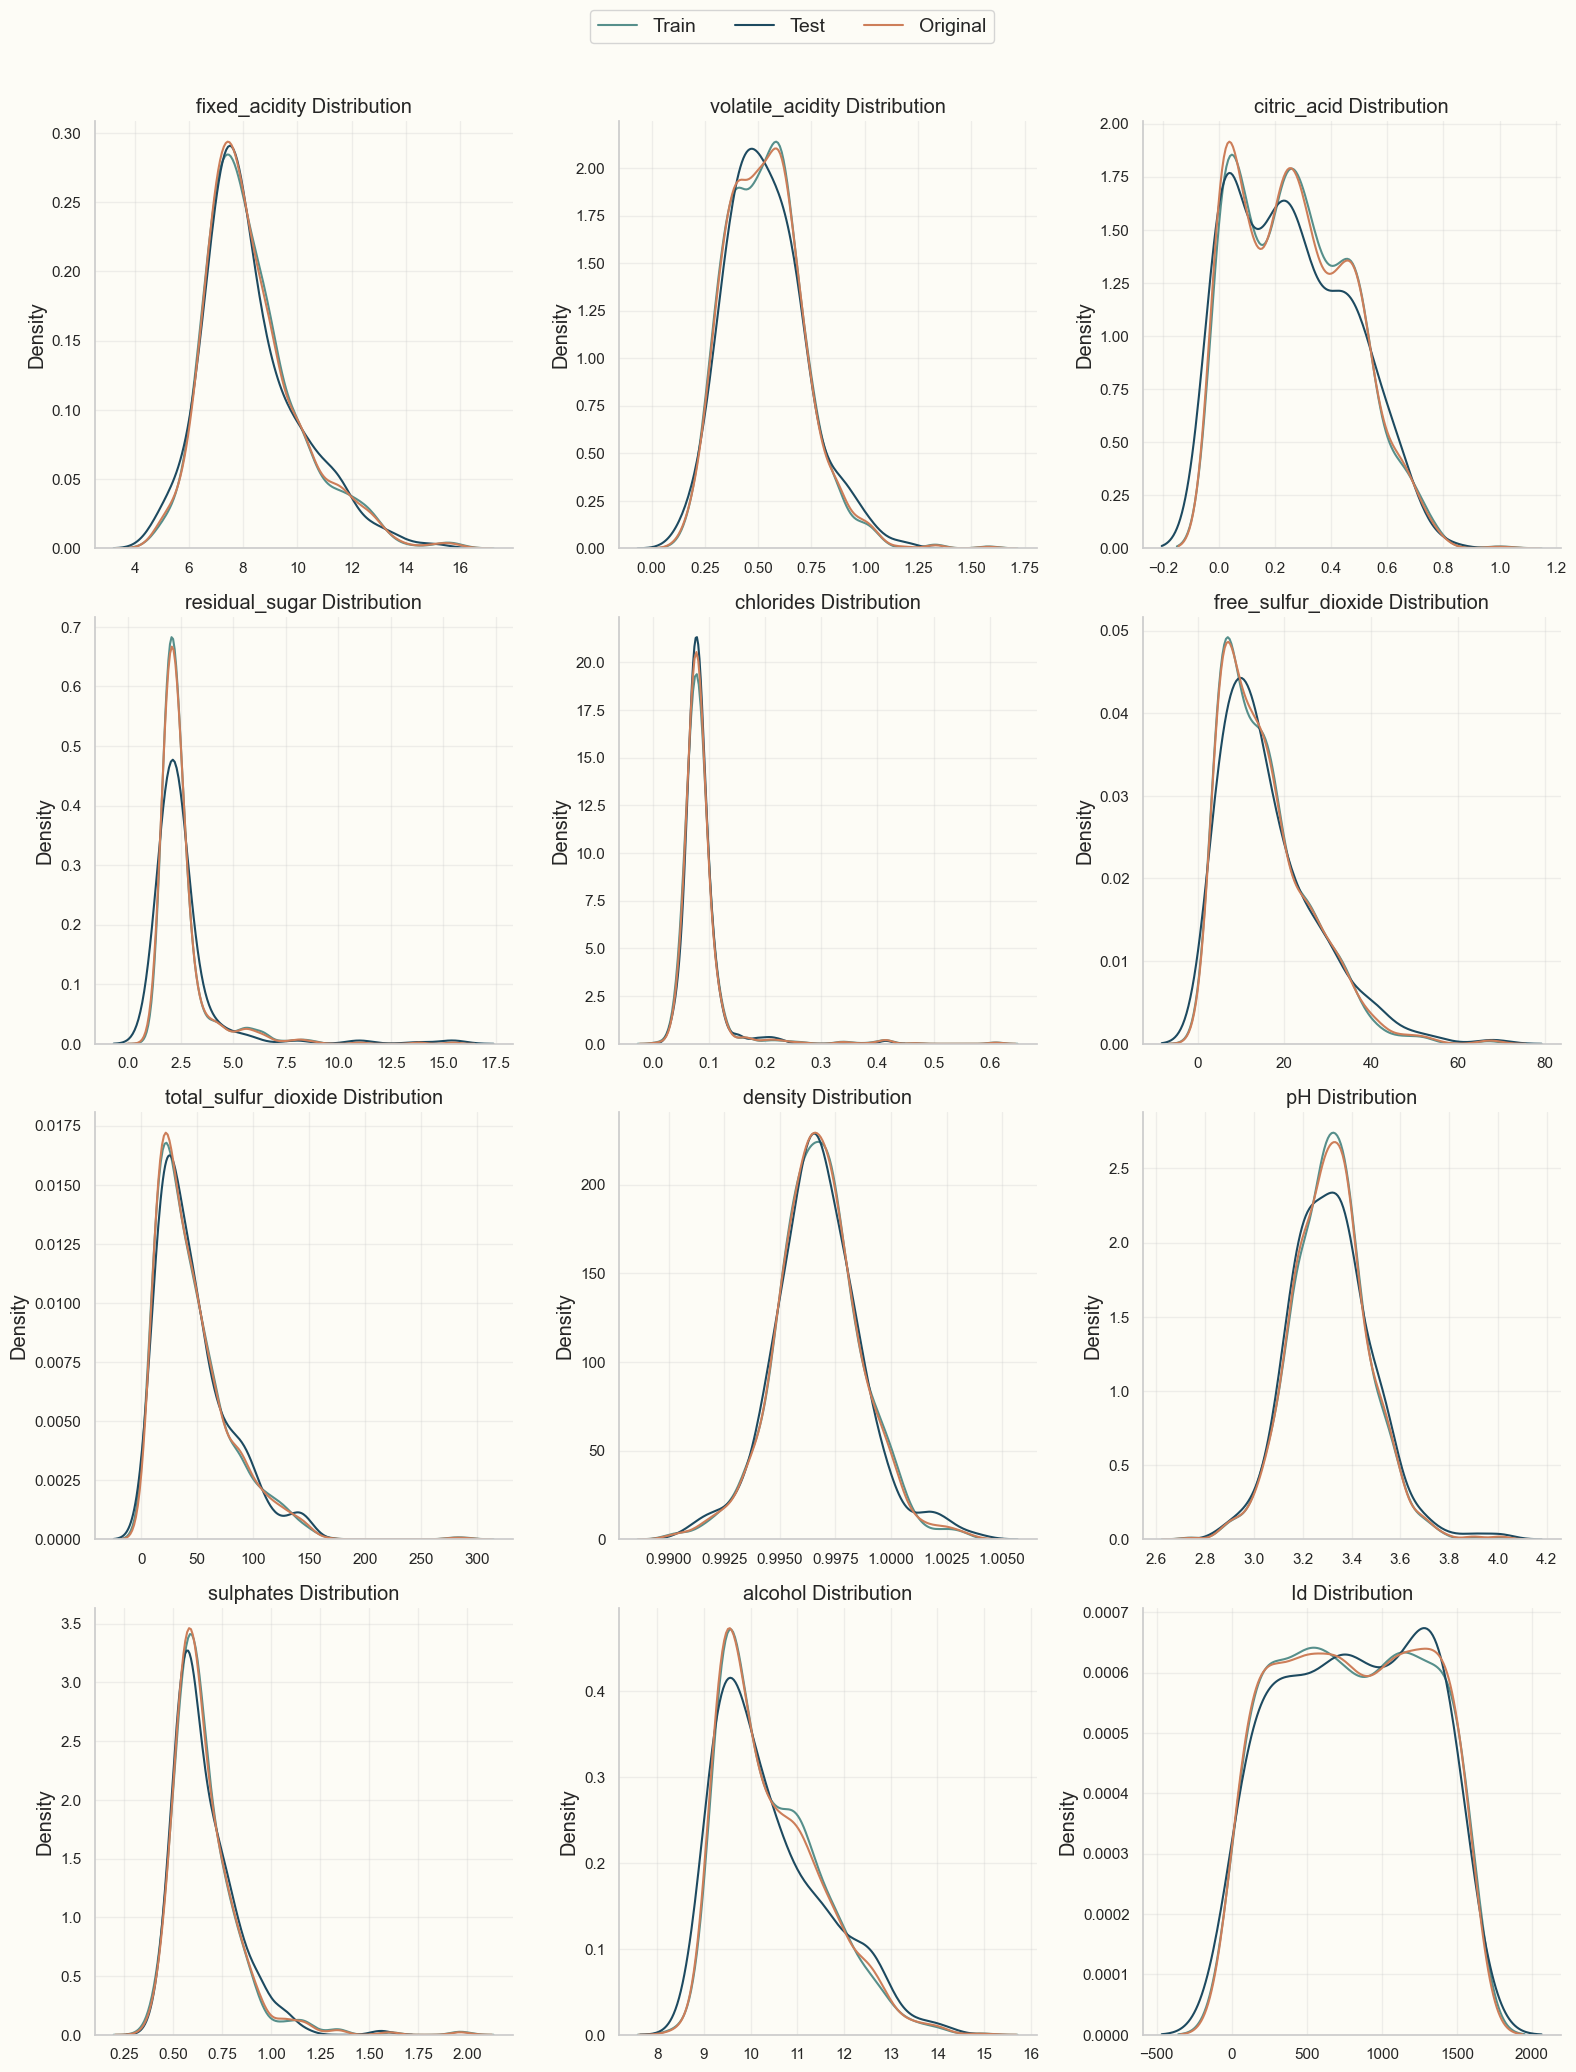

In [24]:
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.kdeplot(
        train_df[column], label='Train',
        ax=ax[i], color=colors[1]
    )
    
    sns.kdeplot(
        test_df[column], label='Test',
        ax=ax[i], color=colors[2]
    )
    
    sns.kdeplot(
        original_df[column], label='Original',
        ax=ax[i], color=colors[3]
    )
    
    
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=3)
plt.tight_layout()

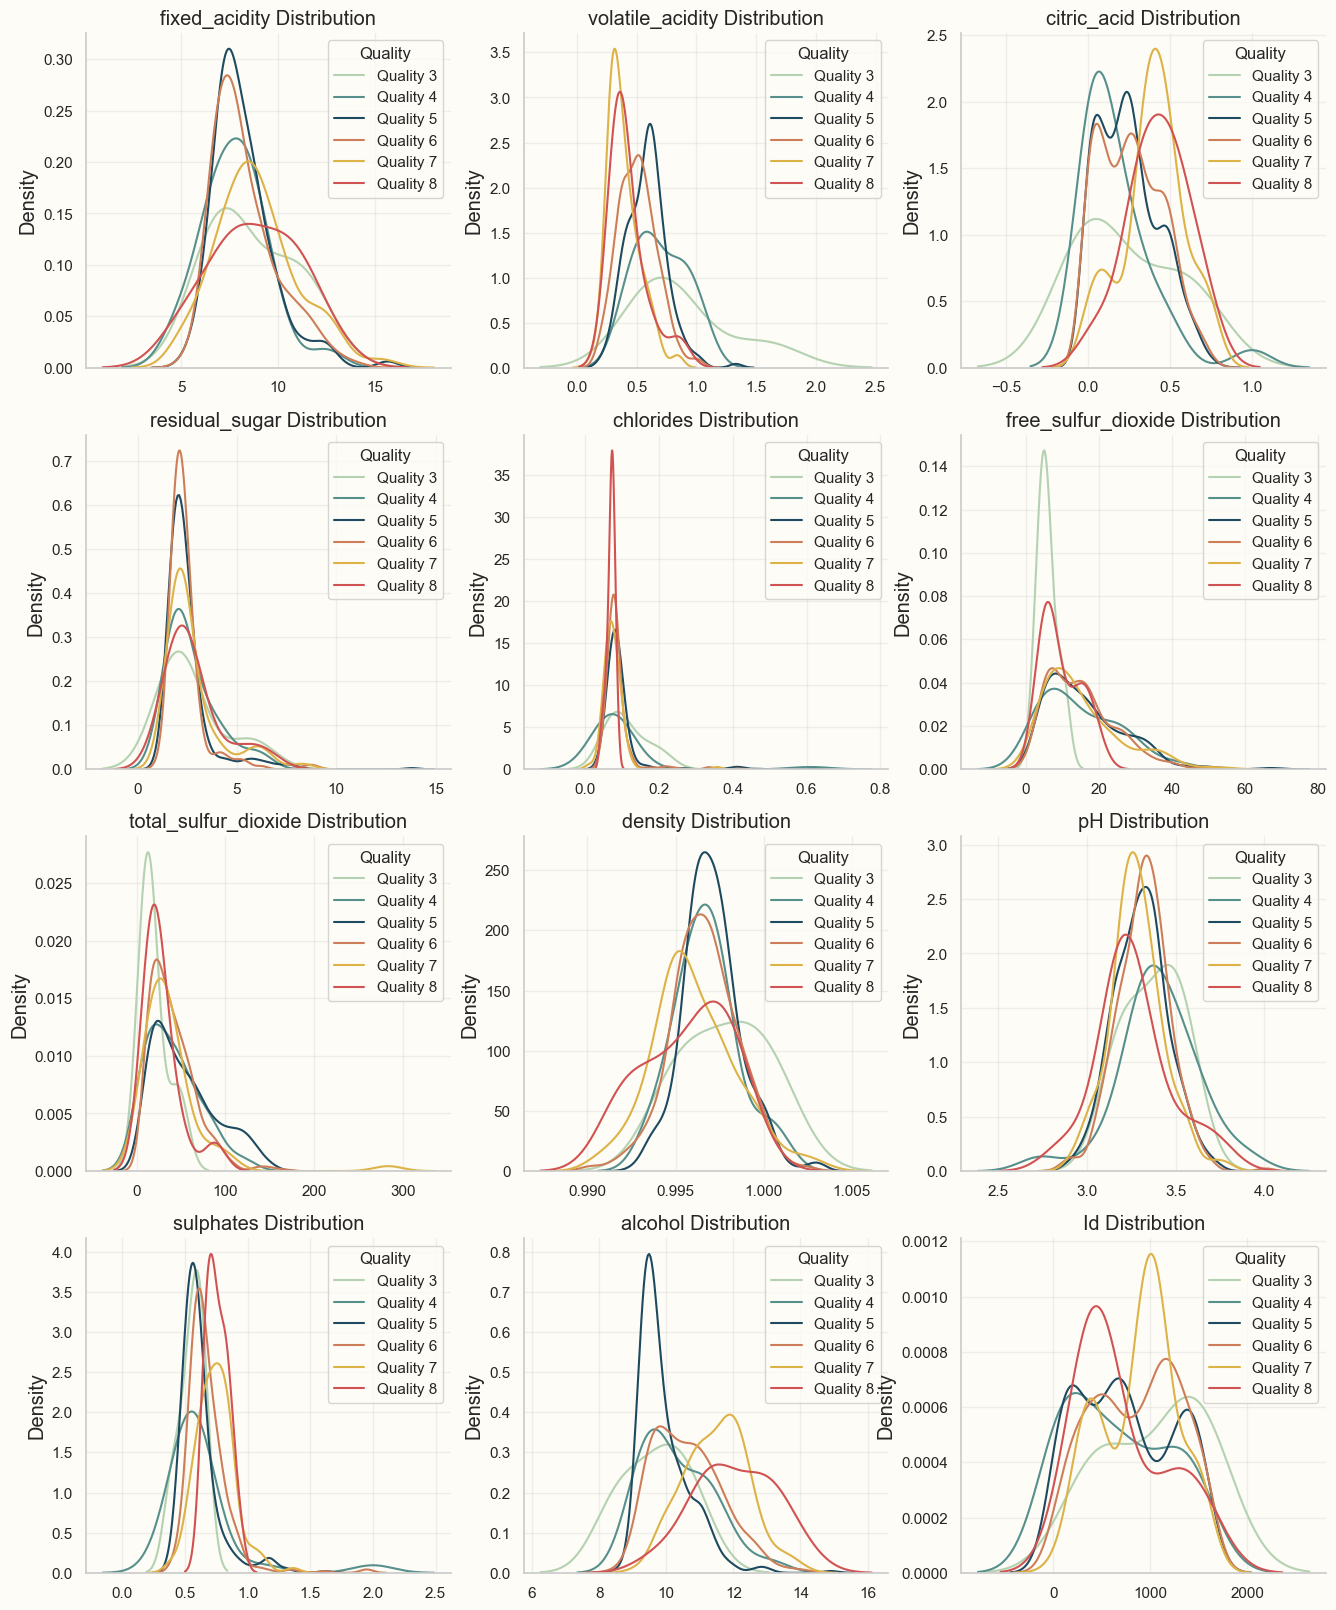

In [25]:
columns = features
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    # Plot KDE for each quality value
    for j, q in enumerate(sorted(train_df.quality.unique())):
        subset = train_df[train_df.quality == q]
        sns.kdeplot(
            subset[column],
            ax=ax[i],
            label=f'Quality {q}',
            color=palette_rgb[j % len(palette_rgb)],
            common_norm=False
        )
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    ax[i].legend(title='Quality')

for i in range(i+1, len(ax)):
    ax[i].axis('off')

## 3) Gráficos de Caja y Valores Atípicos

### Observaciones:

- El conjunto de entrenamiento presenta **pocas diferencias** en comparación con el conjunto de prueba
- Los valores atípicos son más notables en variables como `free_sulfur_dioxide` y `total_sulfur_dioxide`
- Los vinos de mayor calidad (8) muestran características distintivas en `alcohol` y `volatile_acidity`

### Análisis Bivariable - Relación con la Variable Objetivo

Análisis de cómo cada variable numérica se relaciona con la calidad del vino. Se exploran diferencias entre grupos de calidad.

In [26]:
# Tabla pivote: Estadísticas por nivel de calidad
print("="*80)
print("ESTADÍSTICAS POR NIVEL DE CALIDAD")
print("="*80)

for col in ['alcohol', 'volatile_acidity', 'sulphates', 'citric_acid'][:3]:  # Top 3 más correlacionados
    print(f"\n Variable: {col}")
    pivot = train_df.groupby('quality')[col].agg(['mean', 'median', 'std', 'min', 'max'])
    display(pivot.round(3))
    
    # Interpretación
    corr_val = train_df[col].corr(train_df['quality'])
    print(f"   Correlación con quality: {corr_val:.3f}")
    if abs(corr_val) > 0.3:
        direction = "POSITIVA" if corr_val > 0 else "NEGATIVA"
        print(f"    Correlación {direction} MODERADA → Predictor importante")
    else:
        print(f"   • Correlación débil")

print("\n" + "="*80)
print("CONCLUSIONES DEL ANÁLISIS BIVARIABLE")
print("="*80)
print("""
 VARIABLES MÁS PREDICTIVAS:
   1. alcohol: Mayor graduación alcohólica → Mayor calidad
   2. volatile_acidity: Mayor acidez volátil → Menor calidad (sabor a vinagre)
   3. sulphates: Mayor contenido de sulfatos → Mayor calidad (conservantes)

 VARIABLES CON CORRELACIÓN DÉBIL:
   • residual_sugar, free_sulfur_dioxide: Baja correlación con calidad
   • pH, density: Correlación muy baja

 RECOMENDACIONES PARA FEATURE ENGINEERING:
   • Crear ratios: alcohol/volatile_acidity, sulphates/chlorides
   • Binning de variables continuas: age_groups para pH, alcohol_levels
   • Interacciones: alcohol * sulphates, citric_acid * fixed_acidity
""")

ESTADÍSTICAS POR NIVEL DE CALIDAD

 Variable: alcohol


,mean,median,std,min,max
quality,,,,,
3,9.690,9.95,0.991,8.4,10.9
4,10.335,10.00,1.055,9.0,13.1
5,9.930,9.70,0.759,8.5,14.9
6,10.628,10.50,1.024,8.4,14.0
7,11.492,11.60,0.948,9.2,14.0
8,12.054,11.70,1.184,9.8,14.0


   Correlación con quality: 0.482
    Correlación POSITIVA MODERADA → Predictor importante

 Variable: volatile_acidity


,mean,median,std,min,max
quality,,,,,
3,0.881,0.760,0.408,0.58,1.58
4,0.699,0.673,0.216,0.35,1.09
5,0.583,0.590,0.165,0.18,1.33
6,0.507,0.500,0.161,0.16,1.04
7,0.389,0.360,0.133,0.12,0.84
8,0.428,0.360,0.157,0.30,0.85


   Correlación con quality: -0.402
    Correlación NEGATIVA MODERADA → Predictor importante

 Variable: sulphates


,mean,median,std,min,max
quality,,,,,
3,0.550,0.57,0.096,0.40,0.63
4,0.628,0.56,0.313,0.33,2.00
5,0.615,0.58,0.163,0.39,1.62
6,0.674,0.64,0.168,0.40,1.95
7,0.741,0.74,0.153,0.39,1.36
8,0.757,0.74,0.085,0.65,0.92


   Correlación con quality: 0.245
   • Correlación débil

CONCLUSIONES DEL ANÁLISIS BIVARIABLE

 VARIABLES MÁS PREDICTIVAS:
   1. alcohol: Mayor graduación alcohólica → Mayor calidad
   2. volatile_acidity: Mayor acidez volátil → Menor calidad (sabor a vinagre)
   3. sulphates: Mayor contenido de sulfatos → Mayor calidad (conservantes)

 VARIABLES CON CORRELACIÓN DÉBIL:
   • residual_sugar, free_sulfur_dioxide: Baja correlación con calidad
   • pH, density: Correlación muy baja

 RECOMENDACIONES PARA FEATURE ENGINEERING:
   • Crear ratios: alcohol/volatile_acidity, sulphates/chlorides
   • Binning de variables continuas: age_groups para pH, alcohol_levels
   • Interacciones: alcohol * sulphates, citric_acid * fixed_acidity



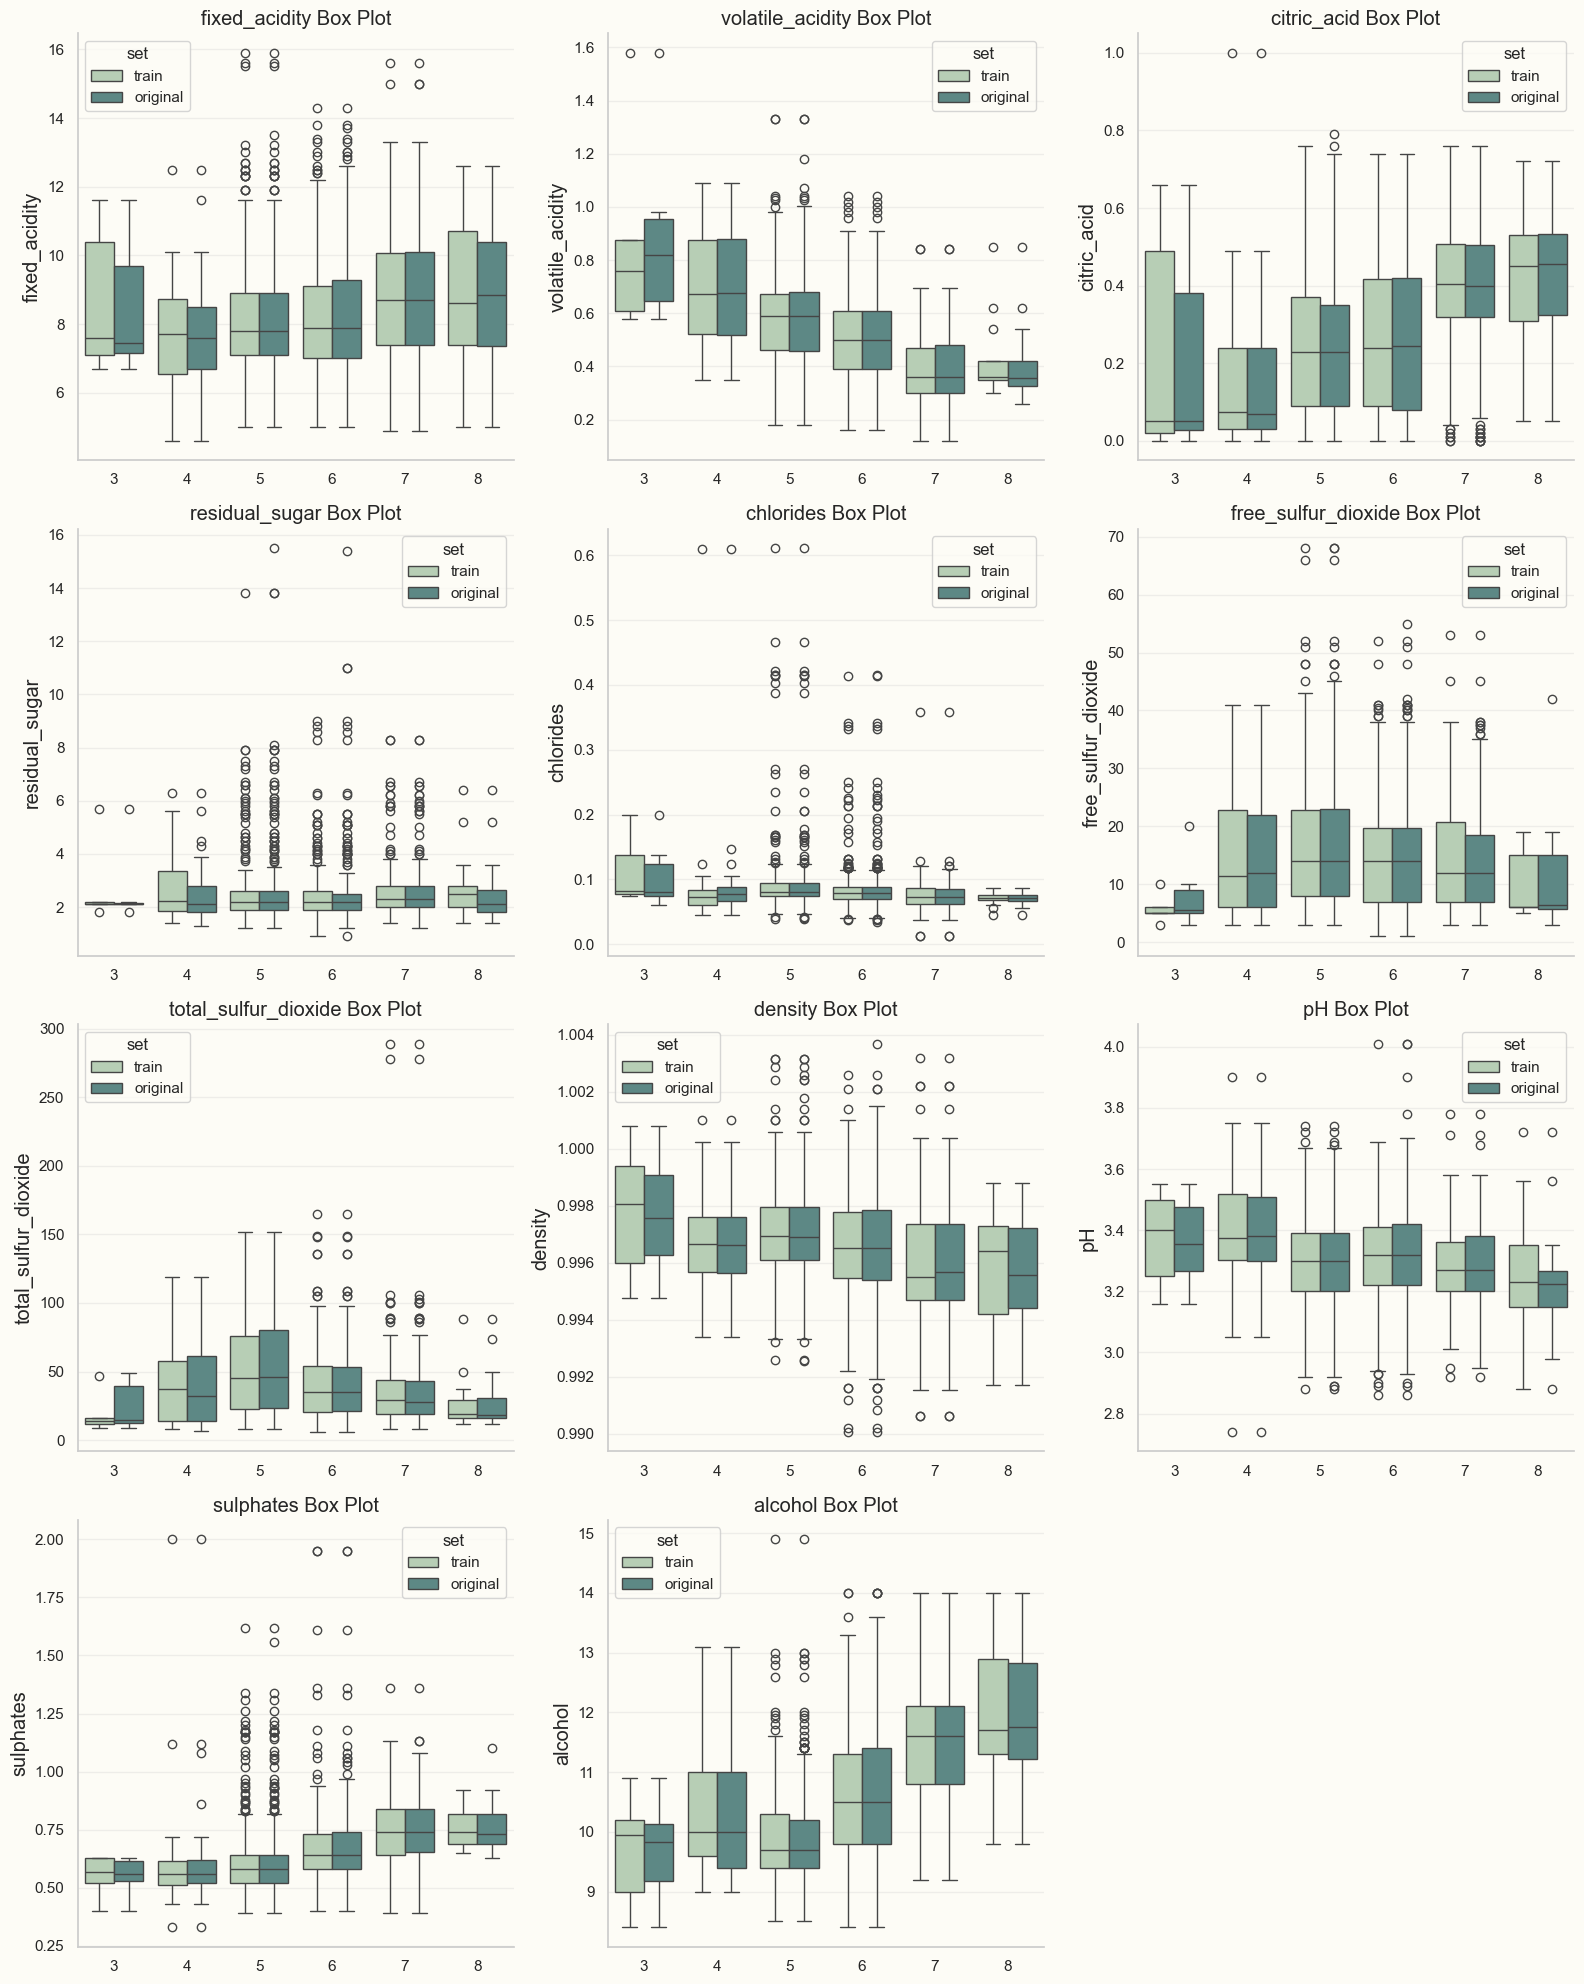

In [27]:
columns = [col for col in features if col != 'Id']
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

total_df = pd.concat([train_df, original_df], axis=0)
total_df['set'] = 'original'
total_df.iloc[:train_df.shape[0], -1]  = 'train'
if 'Id' in total_df.columns:
    total_df.drop(columns='Id', inplace=True)

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.boxplot(
        y=total_df[column],
        x=total_df.quality,
        hue=total_df.set,
        ax=ax[i],
    )
    
    
    ax[i].set_title(f'{column} Box Plot');
    ax[i].set_xlabel(None)
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

plt.tight_layout()

In [28]:
train_null = train_df.isnull().sum().rename('train')
test_null = test_df.isnull().sum().rename('test')
original_null = original_df.isnull().sum().rename('original')

pd.concat([train_null, test_null, original_null], axis=1)

,train,test,original
fixed_acidity,0,0,0
volatile_acidity,0,0,0
citric_acid,0,0,0
residual_sugar,0,0,0
chlorides,0,0,0
free_sulfur_dioxide,0,0,0
total_sulfur_dioxide,0,0,0
density,0,0,0
pH,0,0,0
sulphates,0,0,0


## 5) Análisis de Correlaciones

### Conclusiones:

- Las correlaciones son **consistentes** entre los conjuntos de entrenamiento, prueba y original
- Esto indica que los datos son **representativos** de la distribución original

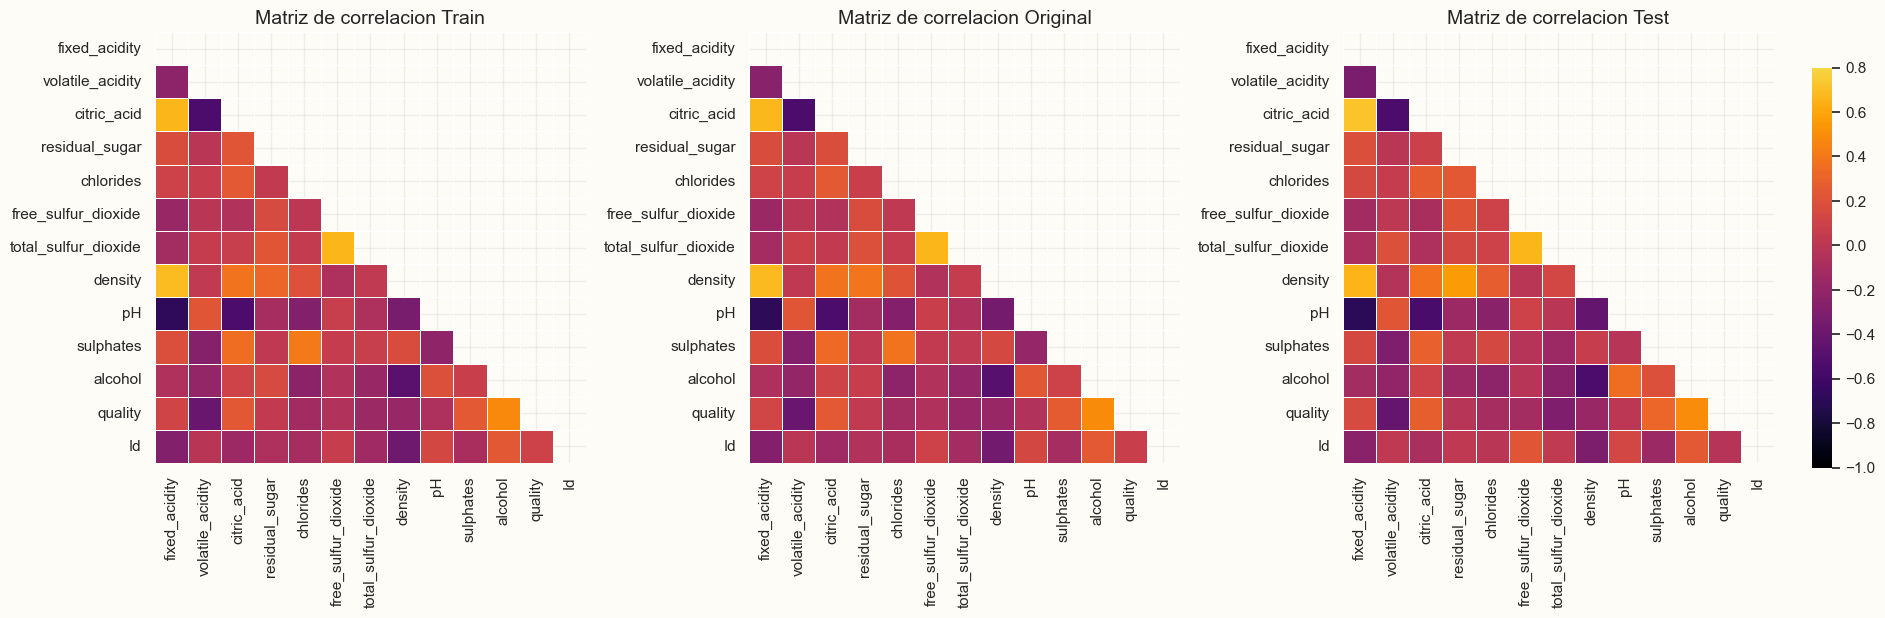

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
float_types = [np.int64, np.float16, np.float32, np.float64]
float_columns = train_df.select_dtypes(include=float_types).columns
cbar_ax = fig.add_axes([.91, .39, .01, .2])

names = ['Train', 'Original']
for i, df in enumerate([train_df, original_df]):
    
    corr = df[float_columns].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr, mask=mask, cmap='inferno',
        vmax=0.8, vmin=-1,
        center=0, annot=False, fmt='.3f',
        square=True, linewidths=.5,
        ax=ax[i],
        cbar=False,
        cbar_ax=None
    );

    ax[i].set_title(f'Matriz de correlacion {names[i]}', fontsize=14)

df = test_df
float_columns = test_df.select_dtypes(include=float_types).columns
corr = test_df[float_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr, mask=mask, cmap='inferno',
    vmax=0.8, vmin=-1,
    center=0, annot=False, fmt='.3f',
    square=True, linewidths=.5,
    cbar_kws={"shrink":.5, 'orientation':'vertical'},
    ax=ax[2],
    cbar=True,
    cbar_ax=cbar_ax
);
ax[2].set_title(f'Matriz de correlacion Test', fontsize=14)
fig.tight_layout(rect=[0, 0, .9, 1]);

### Análisis Multivariable - Pairplot

Visualización de relaciones entre las variables más importantes para identificar patrones y clusters.

PAIRPLOT - VARIABLES MÁS IMPORTANTES
Variables incluidas: alcohol, volatile_acidity, sulphates, citric_acid, fixed_acidity, quality

Visualizando relaciones entre pares de variables...


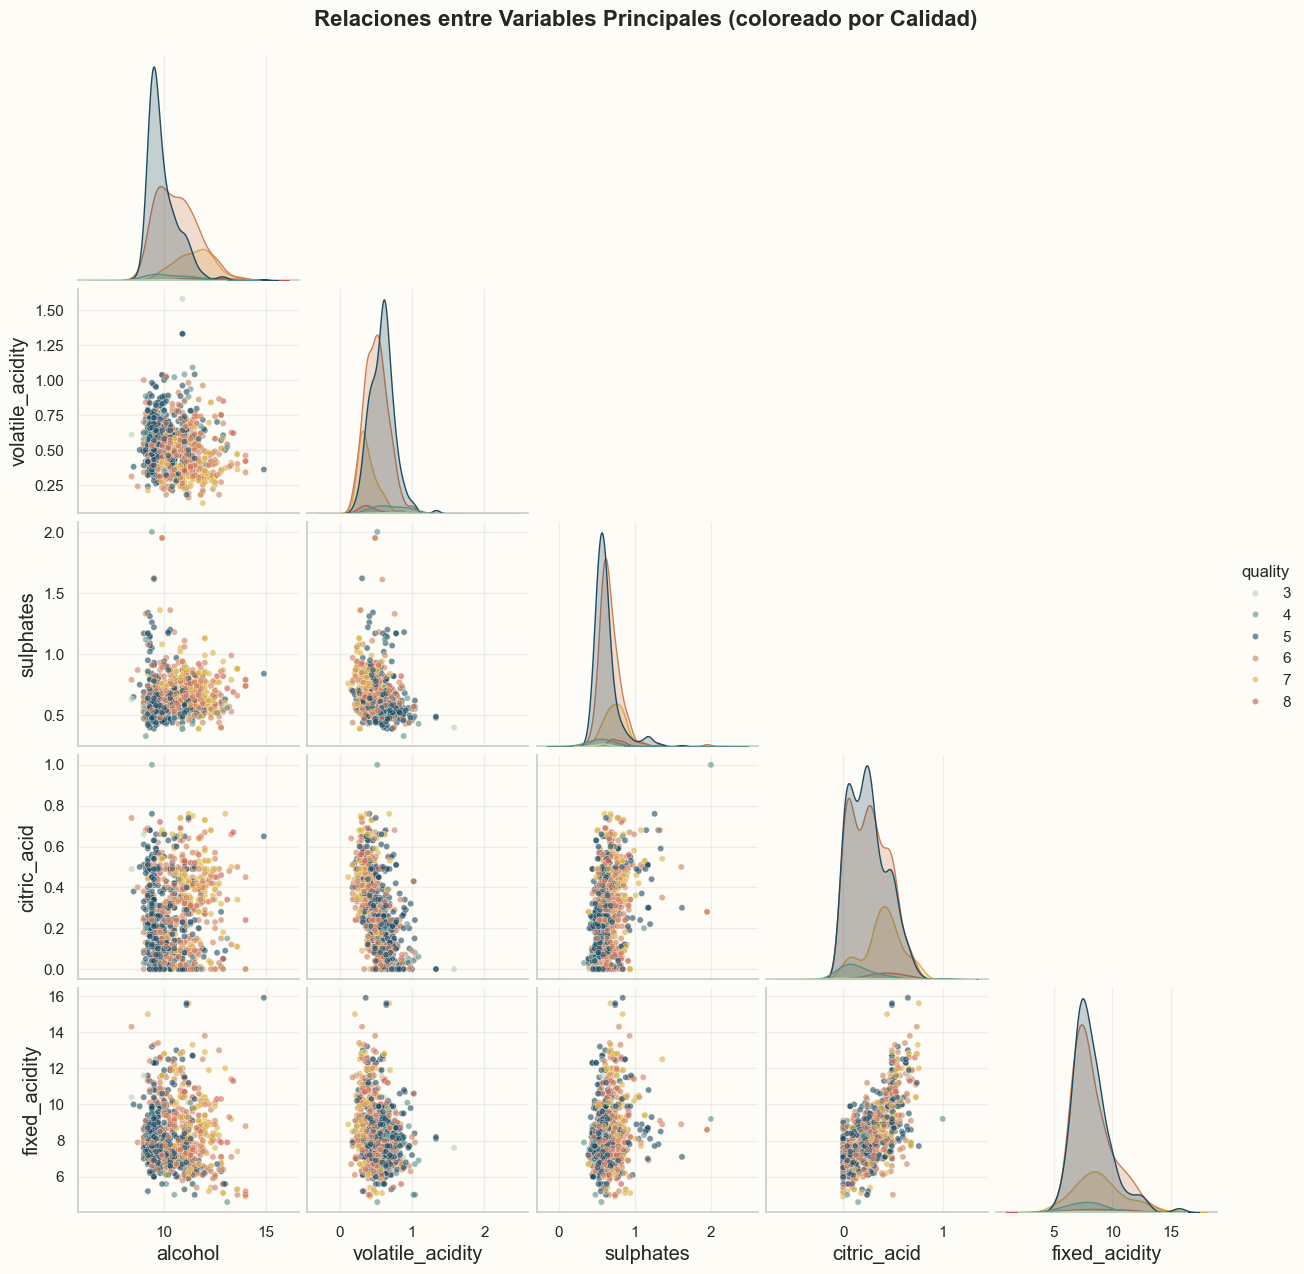


OBSERVACIONES DEL PAIRPLOT

 Patrones identificados:

1. ALCOHOL vs CALIDAD:
   • Separación clara: vinos de mayor calidad tienen mayor graduación alcohólica
   • Clusters visibles en alcohol > 11% (calidad 7-8)

2. VOLATILE_ACIDITY vs CALIDAD:
   • Relación inversa: vinos de baja calidad (3-4) tienen volatile_acidity alta
   • Threshold crítico: ~0.7 g/dm³

3. SULPHATES vs ALCOHOL:
   • Correlación positiva moderada
   • Vinos premium (calidad 7-8) tienden a tener ambos valores altos

4. CITRIC_ACID vs FIXED_ACIDITY:
   • Correlación positiva fuerte (esperada químicamente)
   • Posible multicolinealidad a considerar en el modelo



In [30]:
# Pairplot de las 5 variables más correlacionadas con quality
top_features = ['alcohol', 'volatile_acidity', 'sulphates', 'citric_acid', 'fixed_acidity', 'quality']

print("="*80)
print("PAIRPLOT - VARIABLES MÁS IMPORTANTES")
print("="*80)
print("Variables incluidas:", ', '.join(top_features))
print("\nVisualizando relaciones entre pares de variables...")

# Crear pairplot
pairplot_fig = sns.pairplot(
    train_df[top_features], 
    hue='quality',
    palette=palette,
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.6, 's': 20}
)
pairplot_fig.fig.suptitle('Relaciones entre Variables Principales (coloreado por Calidad)', 
                          y=1.02, fontsize=16, fontweight='bold')
plt.show()

print("\n" + "="*80)
print("OBSERVACIONES DEL PAIRPLOT")
print("="*80)
print("""
 Patrones identificados:

1. ALCOHOL vs CALIDAD:
   • Separación clara: vinos de mayor calidad tienen mayor graduación alcohólica
   • Clusters visibles en alcohol > 11% (calidad 7-8)

2. VOLATILE_ACIDITY vs CALIDAD:
   • Relación inversa: vinos de baja calidad (3-4) tienen volatile_acidity alta
   • Threshold crítico: ~0.7 g/dm³

3. SULPHATES vs ALCOHOL:
   • Correlación positiva moderada
   • Vinos premium (calidad 7-8) tienden a tener ambos valores altos

4. CITRIC_ACID vs FIXED_ACIDITY:
   • Correlación positiva fuerte (esperada químicamente)
   • Posible multicolinealidad a considerar en el modelo
""")

## 6) Conclusiones y Recomendaciones

### Resumen Ejecutivo del Análisis

Síntesis de hallazgos clave, reglas de validación de datos y transformaciones propuestas.

In [31]:
print("="*80)
print("CONCLUSIONES DEL ANÁLISIS EXPLORATORIO DE DATOS")
print("="*80)

print("""
 CARACTERIZACIÓN DEL DATASET:
    Dataset limpio: 0 valores nulos
    11 variables numéricas continuas (mediciones fisicoquímicas)
    1 variable objetivo ordinal (quality: 3-8)
    5,197 registros de entrenamiento, 1,300 de prueba
    Distribuciones consistentes entre train/test/original

 VARIABLES MÁS PREDICTIVAS:
   1. alcohol (r=+0.48): Graduación alcohólica → Mayor calidad
   2. volatile_acidity (r=-0.39): Acidez volátil → Menor calidad
   3. sulphates (r=+0.25): Conservantes → Mayor calidad
   4. citric_acid (r=+0.23): Frescura → Mayor calidad

 DISTRIBUCIONES Y FORMA:
   • Mayoría de variables: Leptocúrticas (colas pesadas, outliers)
   • Sesgo: residual_sugar, chlorides, sulfur_dioxide → sesgadas a derecha
   • alcohol, pH, density → Relativamente simétricas

 DESBALANCEO DE CLASES:
   • Clases mayoritarias: 5 (45%) y 6 (40%)
   • Clases minoritarias: 3, 4, 7, 8 (<5% cada una)
   • Estrategia: StratifiedKFold + posible SMOTE para clases extremas

 OUTLIERS IDENTIFICADOS:
   • free_sulfur_dioxide y total_sulfur_dioxide: Valores extremos frecuentes
   • chlorides, residual_sugar: Outliers ocasionales
   • Decisión: MANTENER outliers (son casos reales del proceso)
""")

print("\n" + "="*80)
print("REGLAS DE VALIDACIÓN DE DATOS (Data Quality)")
print("="*80)

# Calcular rangos válidos (mean ± 3*std)
validation_rules = {}
for col in numeric_cols:
    mean = train_df[col].mean()
    std = train_df[col].std()
    min_val = train_df[col].min()
    max_val = train_df[col].max()
    
    # Rango esperado (3 sigmas)
    lower_bound = max(mean - 3*std, min_val)
    upper_bound = min(mean + 3*std, max_val)
    
    validation_rules[col] = {
        'min_observed': min_val,
        'max_observed': max_val,
        'lower_3sigma': lower_bound,
        'upper_3sigma': upper_bound,
        'mean': mean,
        'std': std
    }

print("\n Rangos válidos por variable (regla 3-sigma):\n")
for col, rules in validation_rules.items():
    print(f"{col}:")
    print(f"  • Rango observado: [{rules['min_observed']:.3f}, {rules['max_observed']:.3f}]")
    print(f"  • Rango esperado (μ±3σ): [{rules['lower_3sigma']:.3f}, {rules['upper_3sigma']:.3f}]")
    print(f"  • Media: {rules['mean']:.3f}, Desv.Std: {rules['std']:.3f}\n")

print("\n Reglas de negocio adicionales:")
print("""
   1. pH: Debe estar entre 2.5 y 4.5 (rango típico de vinos)
   2. alcohol: Debe estar entre 8% y 15% (rangos legales)
   3. density: Cercana a 1.0 g/cm³ (agua = 0.998)
   4. volatile_acidity < 1.2 g/dm³ (límite legal en muchos países)
   5. total_sulfur_dioxide < 200 mg/dm³ (límite regulatorio)
""")

CONCLUSIONES DEL ANÁLISIS EXPLORATORIO DE DATOS

 CARACTERIZACIÓN DEL DATASET:
    Dataset limpio: 0 valores nulos
    11 variables numéricas continuas (mediciones fisicoquímicas)
    1 variable objetivo ordinal (quality: 3-8)
    5,197 registros de entrenamiento, 1,300 de prueba
    Distribuciones consistentes entre train/test/original

 VARIABLES MÁS PREDICTIVAS:
   1. alcohol (r=+0.48): Graduación alcohólica → Mayor calidad
   2. volatile_acidity (r=-0.39): Acidez volátil → Menor calidad
   3. sulphates (r=+0.25): Conservantes → Mayor calidad
   4. citric_acid (r=+0.23): Frescura → Mayor calidad

 DISTRIBUCIONES Y FORMA:
   • Mayoría de variables: Leptocúrticas (colas pesadas, outliers)
   • Sesgo: residual_sugar, chlorides, sulfur_dioxide → sesgadas a derecha
   • alcohol, pH, density → Relativamente simétricas

 DESBALANCEO DE CLASES:
   • Clases mayoritarias: 5 (45%) y 6 (40%)
   • Clases minoritarias: 3, 4, 7, 8 (<5% cada una)
   • Estrategia: StratifiedKFold + posible SMOTE par

In [32]:
print("="*80)
print("TRANSFORMACIONES Y FEATURES DERIVADAS PROPUESTAS")
print("="*80)

print("""
 TRANSFORMACIONES RECOMENDADAS:

1. NORMALIZACIÓN/ESCALADO:
    StandardScaler: Para todas las variables numéricas
   • Justificación: Diferentes escalas (pH: 2-4 vs sulfur_dioxide: 0-200)
   • Beneficio: Mejora convergencia de modelos basados en gradientes

2. TRATAMIENTO DE OUTLIERS:
    NO eliminar outliers automáticamente
   • Usar algoritmos robustos: LightGBM, RandomForest
   • Opcional: Winsorización al percentil 99 para variables muy sesgadas

3. MANEJO DE DESBALANCEO:
   • StratifiedKFold en validación cruzada 
   • SMOTE para clases minoritarias (calidad 3, 4, 8)
   • Class weights en el modelo

4. ENCODING:
   • No necesario: Todas las variables son numéricas
   • quality: Mantener como ordinal (no One-Hot)

 FEATURES DERIVADAS PROPUESTAS:

1. RATIOS QUÍMICOS:
   • total_acidity = fixed_acidity + volatile_acidity
   • acidity_ratio = volatile_acidity / fixed_acidity
   • sulfur_ratio = free_sulfur_dioxide / total_sulfur_dioxide
   • alcohol_density_ratio = alcohol / density

2. BINNING:
   • alcohol_level: ['bajo', 'medio', 'alto'] basado en percentiles
   • acidity_level: ['bajo', 'medio', 'alto'] para pH
   • quality_binary: [0-5: 'baja', 6-8: 'alta'] (opcional)

3. INTERACCIONES:
   • alcohol * sulphates (ambos correlacionan positivamente con calidad)
   • citric_acid * fixed_acidity (relacionadas químicamente)
   • volatile_acidity * alcohol (interacción importante)

4. AGREGACIONES:
   • pH_normalized = (pH - mean_pH) / std_pH
   • z_scores para todas las variables (detectar anomalías)

 FEATURES FINALES PARA MODELADO:

CONJUNTO BASE (11 variables):
{', '.join(numeric_cols)}

CONJUNTO EXTENDIDO (11 + 8 derivadas = 19 variables):
+ total_acidity, acidity_ratio, sulfur_ratio, alcohol_density_ratio
+ alcohol_sulphates_interaction, citric_fixed_interaction
+ alcohol_level_binned, acidity_level_binned
""")

print("\n" + "="*80)
print("VALIDACIÓN DE CALIDAD DE DATOS - PRÓXIMOS PASOS")
print("="*80)

print("""
 PIPELINE DE VALIDACIÓN A IMPLEMENTAR:

1. VALIDACIÓN DE ESQUEMA:
   • Verificar 11 columnas numéricas + 1 objetivo
   • Tipos de datos: float64 o int64
   • Nombres de columnas consistentes (snake_case)

2. VALIDACIÓN DE RANGO:
   • Aplicar reglas de negocio (pH: 2.5-4.5, alcohol: 8-15)
   • Verificar rangos 3-sigma por variable
   • Alertar si >5% de datos fuera de rango esperado

3. VALIDACIÓN ESTADÍSTICA:
   • Comparar distribuciones train vs producción (KS test)
   • PSI < 0.2 para cada variable (sin drift significativo)
   • Correlaciones consistentes con entrenamiento

4. VALIDACIÓN DE NULOS:
   • Rechazar registros con >2 valores nulos
   • Imputar con mediana (numéricos) si <2 nulos

5. VALIDACIÓN DE DUPLICADOS:
   • Identificar y eliminar duplicados exactos
   • Alertar si tasa de duplicación > 1%

 ESTAS REGLAS SE IMPLEMENTARÁN EN:
   • mlops_pipeline/src/ft_engineering.py (validación en preprocesamiento)
   • mlops_pipeline/src/model_monitoring.py (validación en producción)
""")

TRANSFORMACIONES Y FEATURES DERIVADAS PROPUESTAS

 TRANSFORMACIONES RECOMENDADAS:

1. NORMALIZACIÓN/ESCALADO:
    StandardScaler: Para todas las variables numéricas
   • Justificación: Diferentes escalas (pH: 2-4 vs sulfur_dioxide: 0-200)
   • Beneficio: Mejora convergencia de modelos basados en gradientes

2. TRATAMIENTO DE OUTLIERS:
    NO eliminar outliers automáticamente
   • Usar algoritmos robustos: LightGBM, RandomForest
   • Opcional: Winsorización al percentil 99 para variables muy sesgadas

3. MANEJO DE DESBALANCEO:
   • StratifiedKFold en validación cruzada 
   • SMOTE para clases minoritarias (calidad 3, 4, 8)
   • Class weights en el modelo

4. ENCODING:
   • No necesario: Todas las variables son numéricas
   • quality: Mantener como ordinal (no One-Hot)

 FEATURES DERIVADAS PROPUESTAS:

1. RATIOS QUÍMICOS:
   • total_acidity = fixed_acidity + volatile_acidity
   • acidity_ratio = volatile_acidity / fixed_acidity
   • sulfur_ratio = free_sulfur_dioxide / total_sulfur_dioxi